# Spotify Charts – Feature Exploration

This notebook loads the processed Spotify tracks dataset and uses the `charts` module
(PCA + clustering helpers) to create statistical and fancy visualisations of the audio features.


In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from charts import plot_pca_scatter, plot_clustered_pca


sns.set_theme(style="whitegrid")

# Path to the processed features file
DATA_PATH = "data/processed/"

# Load the data
songs = pd.read_csv(DATA_PATH + "songs_with_features.csv")

# Quick overview
songs.head()



,id,artist_names,track_name,source,name,popularity,duration_ms,explicit,artists,id_artists,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,3KkXRkHbMCARz0aVfEt68P,"Post Malone, Swae Lee",Sunflower - Spider-Man: Into the Spider-Verse,Universal Records,Sunflower - Spider-Man: Into the Spider-Verse,85.0,158040.0,0.0,"['Post Malone', 'Swae Lee']","['246dkjvS1zLTtiykXe5h60', '1zNqQNIdeOUZHb8zbZ...",...,2.0,-5.574,1.0,0.0466,0.556,0.000000,0.0703,0.913,89.911,4.0
1,6MWtB6iiXyIwun0YzU6DFP,Post Malone,Wow.,Republic Records,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2rPE9A1vEgShuZxxzR2tZH,Ariana Grande,"thank u, next",Republic Records,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5p7ujcrUXASCNwRaWNHR1C,Halsey,Without Me,Capitol Records,Without Me,83.0,201661.0,1.0,['Halsey'],['26VFTg2z8YR0cCuwLzESi2'],...,6.0,-7.050,1.0,0.0705,0.297,0.000009,0.0936,0.533,136.041,4.0
4,5iwz1NiezX7WWjnCgY5TH4,"Pedro Capó, Farruko",Calma - Remix,Sony Music Latin,Calma - Remix,79.0,238200.0,0.0,"['Pedro Capó', 'Farruko']","['4QVBYiagIaa6ZGSPMbybpy', '329e4yvIujISKGKz1B...",...,11.0,-4.218,0.0,0.0524,0.323,0.000000,0.1430,0.761,126.899,4.0


In [74]:
# list nan values in id column
songs[songs["id"].isna()]

,id,artist_names,track_name,source,name,popularity,duration_ms,explicit,artists,id_artists,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature


In [ ]:
songs.columns


Index(['id', 'artist_names', 'track_name', 'source', 'name', 'popularity',
       'duration_ms', 'explicit', 'artists', 'id_artists', 'release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'],
      dtype='object')

In [76]:
def get_id_list(songs = songs):
    # group by artist_names and track_name and list track ids
    id_list = songs.groupby(["artist_names", "track_name"])["id"].apply(set).reset_index()

    id_list["length"] = id_list["id"].apply(len)
    
    return id_list[id_list["length"] == 0].size, id_list[id_list["length"] > 1].size

without_id, with_multiple_ids = get_id_list()

# filter with lists of lenght > 1 
print("Number of songs without ID: {}/{}".format(without_id, songs.size))
print("Number of songs with multiple IDs: {}/{}".format(with_multiple_ids, songs.size))

Number of songs without ID: 0/965885
Number of songs with multiple IDs: 2172/965885


In [ ]:
# Group by artist_names 

without_id, with_multiple_ids = get_id_list()
print("Number of songs without ID: {}/{}".format(without_id, songs.size))
print("Number of songs with multiple IDs: {}/{}".format(with_multiple_ids, songs.size))

ValueError: attempt to get argmin of an empty sequence

25/12/02 06:05:28 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1004826 ms exceeds timeout 120000 ms
25/12/02 06:05:28 WARN SparkContext: Killing executors is not supported by current scheduler.
25/12/02 06:20:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

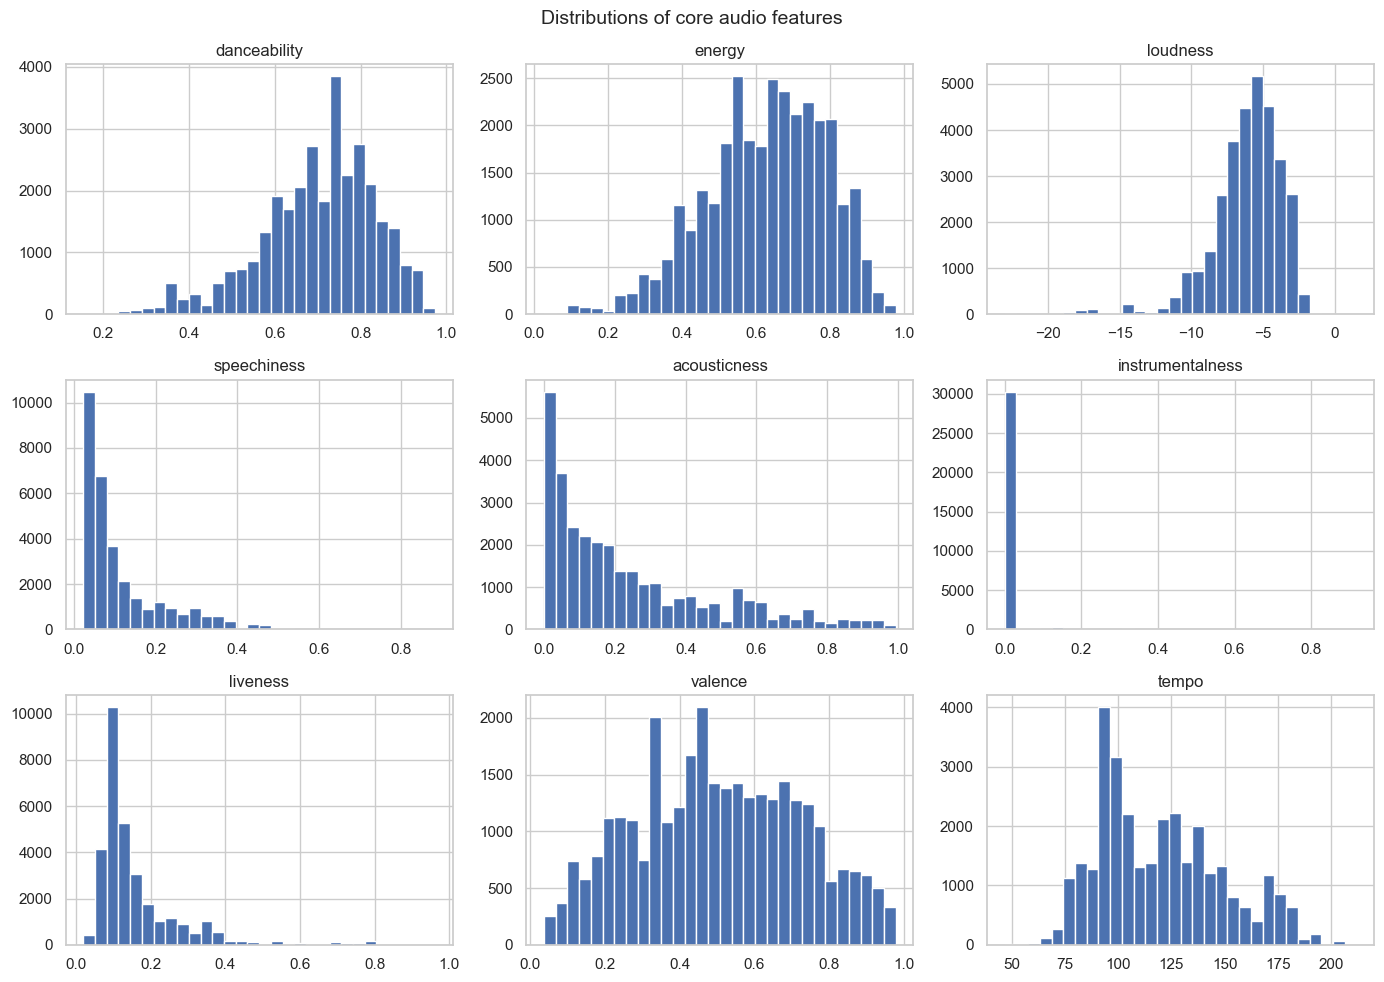

In [2]:
# Basic distribution plots for key audio features
numeric_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

available = [c for c in numeric_cols if c in songs.columns]

songs[available].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distributions of core audio features", fontsize=14)
plt.tight_layout()
plt.show()


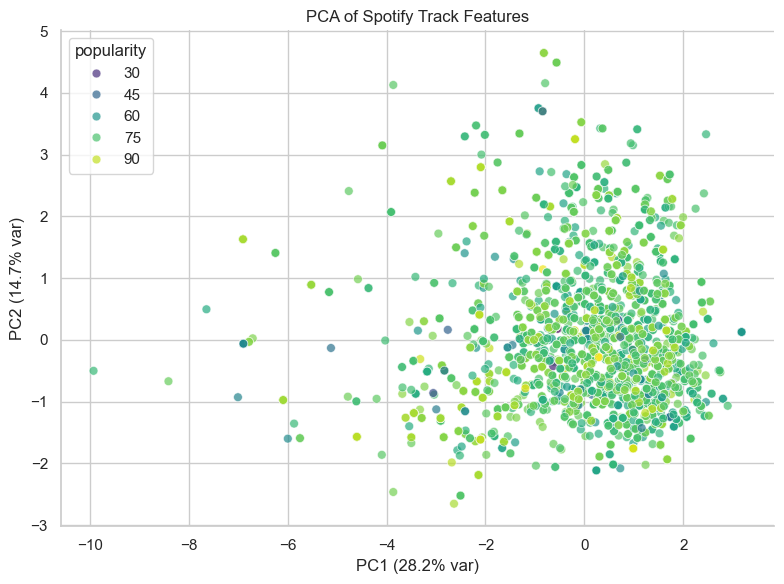

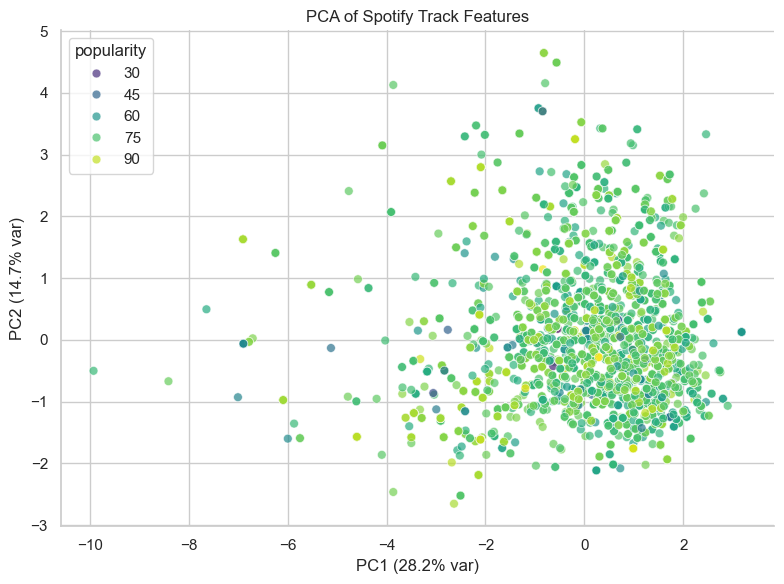

In [3]:
# PCA scatter: 2D embedding of tracks based on audio features

fig, ax, pca_res = plot_pca_scatter(
    songs,
    feature_cols=numeric_cols,
    hue="popularity" if "popularity" in songs.columns else None,
    n_components=2,
    standardize=True,
    sample=3000,
)
fig


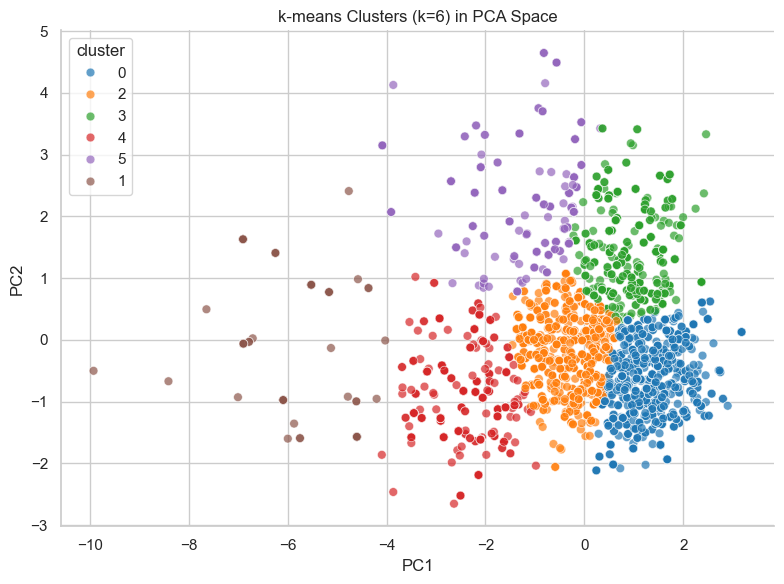

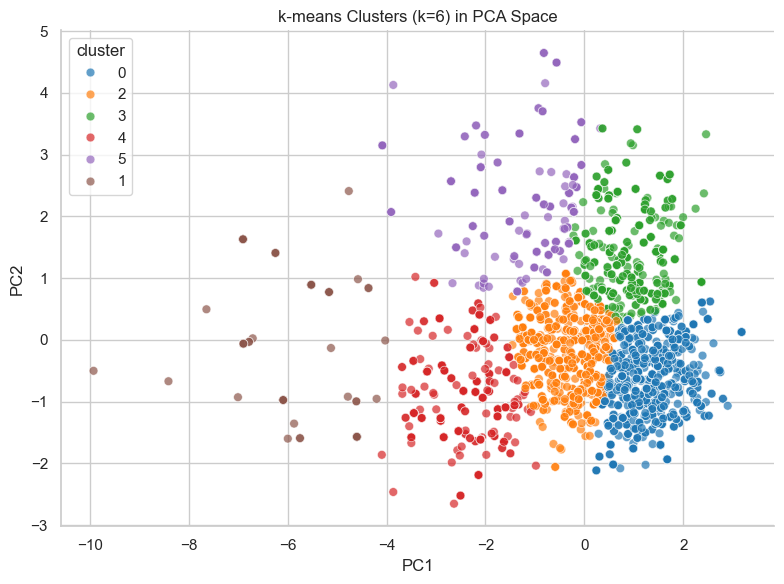

In [4]:
# k-means clustering visualised in PCA space

fig, ax, cluster_res = plot_clustered_pca(
    songs,
    feature_cols=numeric_cols,
    n_clusters=6,
    n_components=2,
    standardize=True,
    sample=3000,
)
fig
